In [61]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

El dataset cuenta con información sobre los potenciales clientes. Estas personas solicitaron una hipoteca, pero no se muestra si la venta llego al proceso final.

In [62]:
df = pd.read_csv('data/dataset_v1.csv')
df.head(2)

,ID,Amount,Loan Duration,Debt Ratio,Mortgage Rate,Tax And Expenses,User Birthdate,User Work,User Salary,User 2 Birthdate,User 2 Work,User 2 Salary,Mortgage Mode,Property Value,Solicitor Type,Combined Salary
0,d2265bbd-310a-4873-ba86-e7eca4d80db1,173000.0,20,40.0,65,0.0,1970-09-21,1,3000.0,1972-09-26,1,900.0,2,270000.0,2,3900.0
1,3fb34747-f877-4698-a088-472d952467a5,136000.0,25,38.0,71,23040.0,1982-08-20,1,1300.0,1982-04-28,1,1250.0,2,192000.0,2,2550.0


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6312 entries, 0 to 6311
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                6312 non-null   object 
 1   Amount            6312 non-null   float64
 2   Loan Duration     6312 non-null   int64  
 3   Debt Ratio        6311 non-null   float64
 4   Mortgage Rate     6312 non-null   int64  
 5   Tax And Expenses  6312 non-null   float64
 6   User Birthdate    6312 non-null   object 
 7   User Work         6312 non-null   int64  
 8   User Salary       6312 non-null   float64
 9   User 2 Birthdate  3533 non-null   object 
 10  User 2 Work       6312 non-null   int64  
 11  User 2 Salary     6312 non-null   float64
 12  Mortgage Mode     6312 non-null   int64  
 13  Property Value    6312 non-null   float64
 14  Solicitor Type    6312 non-null   int64  
 15  Combined Salary   6312 non-null   float64
dtypes: float64(7), int64(6), object(3)
memory 

In [64]:
mask_solo_un_propietario = df['User 2 Birthdate'].isnull() != True
mask_solo_un_propietario2 = df['User 2 Salary'] < 1 
df[mask_solo_un_propietario & mask_solo_un_propietario2].head(2)


,ID,Amount,Loan Duration,Debt Ratio,Mortgage Rate,Tax And Expenses,User Birthdate,User Work,User Salary,User 2 Birthdate,User 2 Work,User 2 Salary,Mortgage Mode,Property Value,Solicitor Type,Combined Salary
48,fd48575f-85aa-4d40-8544-3533e8512798,80750.0,30,35.0,95,10200.0,1985-07-27,1,1500.0,1971-11-02,3,0.0,1,85000.0,2,1500.0
82,0db877a6-6fd2-4cc0-a035-54396566fa57,106849.0,29,26.0,68,0.0,1988-08-11,1,0.0,1997-06-21,1,0.0,2,157421.0,2,0.0


El dataset no presenta datos faltantes
Cuando solo hay un usuario, los datos de user2 se presentan como: 
- Fecha de nacimiento: NaN - 2779
- Trabajo: 0
- Salario: 0 - 2924

La diferencia se encuentra en personas que piden salario juntos, pero la segunda personas está en el paro

In [65]:
# Tenemos más hipotecas individuales o compartidas?


Cargamos los datasets de registros y solicitudes de hipoteca

In [66]:
df_registros = pd.read_csv('data/registros.csv')
df_solicitudes = pd.read_csv('data/solicitudes_de_hipoteca.csv')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_25592\771525710.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_registros = pd.read_csv('data/registros.csv')
C:\Users\Pablo\AppData\Local\Temp\ipykernel_25592\771525710.py:2: DtypeWarning: Columns (5,6,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_solicitudes = pd.read_csv('data/solicitudes_de_hipoteca.csv')


In [67]:
df_registros.head(2)

,user,created,firstname,lastname,phone,additional,last_access,nbric_data,nbric_solicitud,id,verified,opt_in
0,ivanllama96@gmail.com,2025-05-18T14:17:24.340136+02:00,Iván,Llamazares rodríguez,+34662666642,"{""referral"": """", ""has_default_password"": true}",2025-05-18T14:17:25.625119+02:00,NaN,NaN,1c7d8492-55f5-4f2a-8b2e-8722d9dd4af7,False,True
1,ikertapia@hotmail.com,2025-05-18T11:36:40.215805+02:00,Iker,Tapia saez,+34665722207,"{""ref"": ""https://www.google.com/"", ""url"": ""htt...",2025-05-18T11:36:41.499893+02:00,NaN,NaN,d7a33186-e783-4f41-919e-2049e178060d,False,True


In [68]:
df_registros_clean = df_registros.loc[:, ['user', 'id']]
df_registros_clean.columns = ['user', 'id_user']
df_registros_clean.head(2)

,user,id_user
0,ivanllama96@gmail.com,1c7d8492-55f5-4f2a-8b2e-8722d9dd4af7
1,ikertapia@hotmail.com,d7a33186-e783-4f41-919e-2049e178060d


In [69]:
df_solicitudes.head(2)

,id,user,mortgage_data,created,ends,nbric_data,nbric_solicitud,status,document_status,fullname,...,main_user_complete_truelayer,partner_complete_truelayer,crm_current_step,scoring,crm_bidder_last_comment,crm_bidder_last_value,timeline_version,is_ocr_auto_activated,is_document_complete,matching
0,b9e84995-2c9e-41ad-a256-adfeb60dbc0a,ikeravista@hotmail.com,"{""data"": {""amount"": 147000.0, ""period"": 20, ""d...",2025-05-18T15:24:39.103635+02:00,2025-05-19T15:24:39.246944+02:00,NaN,NaN,active,pending,Iker Orrantia Montes,...,False,False,NaN,NaN,NaN,NaN,v2,False,False,True
1,6de9aa20-ff72-43fc-9e93-db339a601f94,ivanllama96@gmail.com,"{""data"": {""amount"": 85500.0, ""period"": 20, ""de...",2025-05-18T14:22:54.305455+02:00,2025-05-19T14:22:54.473434+02:00,NaN,NaN,active,pending,Iván Llamazares Rodríguez,...,False,False,NaN,NaN,NaN,NaN,v2,False,False,True


In [70]:
df_solicitudes_clean = df_solicitudes.loc[:, ['id', 'user', 'mortgage_data']]
df_solicitudes_clean.columns = ['id_solicitud', 'user', 'mortgage_data']
df_solicitudes_clean.head(2)

,id_solicitud,user,mortgage_data
0,b9e84995-2c9e-41ad-a256-adfeb60dbc0a,ikeravista@hotmail.com,"{""data"": {""amount"": 147000.0, ""period"": 20, ""d..."
1,6de9aa20-ff72-43fc-9e93-db339a601f94,ivanllama96@gmail.com,"{""data"": {""amount"": 85500.0, ""period"": 20, ""de..."


In [71]:
prueba = json.loads(df_solicitudes_clean['mortgage_data'][2])
prueba.keys()

dict_keys(['data', 'user', 'user_2', 'revenue', 'mortgage', 'property', 'current_bank', 'temp_uploads', 'form_init_date', 'solicitor_type', 'mortgage_initial', 'property_existence', 'customer_application_situation'])

In [72]:
cantidad_hipo = prueba['data']['amount']
debt_ratio = prueba['data']['debtRatio']
total_income = prueba['revenue']['monthly'] # per month
date_solicitud = prueba['form_init_date']
pago_inicial = prueba['mortgage_initial']
mortgage_rate = prueba['data']['mortgage_rate']

pago_inicial

62800

In [73]:
#data_solicitudes =json.loads(df_solicitudes_clean['mortgage_data'])
amount = []
debt_ratio = []
total_income = []
date = []
mortgage_inital = []
mortgage_rate = []

for i in range(df_solicitudes.shape[0]):
    solicitud = json.loads(df_solicitudes_clean['mortgage_data'][i])
    amount.append(solicitud.get('data', {}).get('amount', None))
    total_income.append(solicitud.get('revenue',{}).get('monthly', None))
    debt_ratio.append(solicitud.get('data',{}).get('debtRatio', None))
    date.append(solicitud.get('form_init_date', None))
    mortgage_inital.append(solicitud.get('mortgage_initial', None))
    mortgage_rate.append(solicitud.get('data',{}).get('mortgage_rate',None))

In [74]:
print(np.shape(amount),
np.shape(debt_ratio),
np.shape(total_income),
np.shape(date),
np.shape(mortgage_inital),
np.shape(mortgage_rate))

(62268,) (62268,) (62268,) (62268,) (62268,) (62268,)


In [75]:

df_info_solicitud = pd.DataFrame({
    'amount': amount,
    'debt_ratio': debt_ratio,
    'total_income': total_income,
    'date': date,
    'mortgage_inital': mortgage_inital,
    'mortgage_rate': mortgage_rate
})

In [76]:
df_solicitudes_clean_2 = pd.concat([df_solicitudes_clean, df_info_solicitud], axis=1)
df_solicitudes_clean_2 = df_solicitudes_clean_2.drop('mortgage_data',axis=1)

In [77]:
df_solicitudes_clean_2.head(2)

,id_solicitud,user,amount,debt_ratio,total_income,date,mortgage_inital,mortgage_rate
0,b9e84995-2c9e-41ad-a256-adfeb60dbc0a,ikeravista@hotmail.com,147000.0,39.0,2200.0,2025-05-18T13:19:48.583Z,0,67.0
1,6de9aa20-ff72-43fc-9e93-db339a601f94,ivanllama96@gmail.com,85500.0,21.0,2400.0,2025-05-18T12:15:20.292Z,9500,90.0


In [78]:
df_registros_y_solicitudes = pd.merge(left=df_registros_clean, right=df_solicitudes_clean_2, left_on='user', right_on='user', how='inner')
df_registros_y_solicitudes.head(2)

,user,id_user,id_solicitud,amount,debt_ratio,total_income,date,mortgage_inital,mortgage_rate
0,ivanllama96@gmail.com,1c7d8492-55f5-4f2a-8b2e-8722d9dd4af7,6de9aa20-ff72-43fc-9e93-db339a601f94,85500.0,21.0,2400.0,2025-05-18T12:15:20.292Z,9500,90.0
1,moonlobl@gmail.com,3aca7ac5-a2c2-4a7a-be0d-5d356ee3abd9,4094b507-c1cb-4e26-b2a6-612a549bb1e5,52000.0,16.0,1450.0,2025-05-17T14:27:28.680Z,13000,80.0


In [79]:
df_registros_y_solicitudes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61901 entries, 0 to 61900
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user             61901 non-null  object 
 1   id_user          61901 non-null  object 
 2   id_solicitud     61901 non-null  object 
 3   amount           61901 non-null  object 
 4   debt_ratio       51147 non-null  float64
 5   total_income     61901 non-null  object 
 6   date             52044 non-null  object 
 7   mortgage_inital  61901 non-null  object 
 8   mortgage_rate    56523 non-null  float64
dtypes: float64(2), object(7)
memory usage: 4.3+ MB


In [80]:
df_ofertas = pd.read_csv('data/ofertas.csv')
df_ofertas_aceptadas = pd.read_csv('data/ofertas_aceptadas.csv')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_25592\3103327759.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ofertas = pd.read_csv('data/ofertas.csv')


In [81]:
df_ofertas.head(2)

,id,interest_rate,conditions,bidder_id,mortgage_id,created,bid_for,conditions_details,general_fees,interest_data,calculated,is_merged,is_auto,additional_detail,is_active,status
0,88c1f805-7105-4a09-bbc2-8251fd1107f3,0.00,{},6e64183d-0651-45db-9ab9-2edddf23f7a2,6e2af030-b8f9-450e-ab00-431b4a0727d5,2025-05-18T19:20:45.856859+02:00,"{""id"": 107, ""logo"": null, ""name"": ""ING"", ""hidd...","[{""code"": ""b01"", ""allow"": true, ""interest_rate...","{""values"": {""net_fees"": 1700.0, ""total_fees"": ...","{""mode"": ""mixto"", ""interest"": [{""mode"": ""fijo""...","{""deposit"": 24000, ""monthly"": 388.461053185204...",False,True,NaN,True,pending
1,005d1ec8-a0be-4840-876e-4d588f082b99,2.09,{},eecfc900-0c6e-4961-b842-770e98e5b2e7,b21e4b70-fab9-4de1-a6b2-a463344ddd38,2025-05-18T19:18:12.565669+02:00,"{""id"": 77, ""logo"": null, ""name"": ""Caja Rural d...","[{""code"": ""b01"", ""allow"": true, ""interest_rate...","{""values"": {""net_fees"": 0, ""total_fees"": 0, ""c...","{""mode"": ""fijo"", ""rate"": ""2.09""}","{""deposit"": 51000, ""monthly"": 426.515395312381...",False,True,2.09% FIJO los primeros 12 meses. A partir de ...,True,accepted


In [82]:
df_ofertas_clean = df_ofertas.loc[:, ['id', 'mortgage_id', 'status']]
df_ofertas_clean.columns = ['id_oferta', 'mortgage_id', 'status_oferta']
df_ofertas_clean.head(2)

,id_oferta,mortgage_id,status_oferta
0,88c1f805-7105-4a09-bbc2-8251fd1107f3,6e2af030-b8f9-450e-ab00-431b4a0727d5,pending
1,005d1ec8-a0be-4840-876e-4d588f082b99,b21e4b70-fab9-4de1-a6b2-a463344ddd38,accepted


In [83]:
df_ofertas_aceptadas.head(20)
df_ofertas_aceptadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19366 entries, 0 to 19365
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   id                          19366 non-null  int64 
 1   bidder_accepted             8758 non-null   object
 2   solicitor_accepted          19366 non-null  object
 3   bid_id                      19366 non-null  object
 4   seen                        11561 non-null  object
 5   accept_financed_commission  19366 non-null  bool  
 6   closed_at                   6996 non-null   object
dtypes: bool(1), int64(1), object(5)
memory usage: 926.8+ KB


In [84]:
df_ofertas_aceptadas_clean = df_ofertas_aceptadas.loc[:, ['id', 'bid_id', 'closed_at']]
df_ofertas_aceptadas_clean.columns = ['id_oferta_aceptada', 'bid_id', 'closed_at']
df_ofertas_aceptadas_clean.head(2)

,id_oferta_aceptada,bid_id,closed_at
0,19916,005d1ec8-a0be-4840-876e-4d588f082b99,NaN
1,19915,578cf6e6-40f4-4f00-a7fe-4432eafac86c,NaN


In [85]:
df_ofertas_merged = pd.merge(left=df_ofertas_clean, right=df_ofertas_aceptadas_clean, left_on='id_oferta', right_on='bid_id')
df_ofertas_merged.head()

,id_oferta,mortgage_id,status_oferta,id_oferta_aceptada,bid_id,closed_at
0,005d1ec8-a0be-4840-876e-4d588f082b99,b21e4b70-fab9-4de1-a6b2-a463344ddd38,accepted,19916,005d1ec8-a0be-4840-876e-4d588f082b99,NaN
1,578cf6e6-40f4-4f00-a7fe-4432eafac86c,f8e0dfcf-0f58-4985-bf0f-825d91b0328d,accepted,19915,578cf6e6-40f4-4f00-a7fe-4432eafac86c,NaN
2,2c369c9f-bc1d-4abd-b2c2-de2231c86fa8,35f65000-638e-4cf9-aa09-72af00f5c606,accepted,19912,2c369c9f-bc1d-4abd-b2c2-de2231c86fa8,NaN
3,070233e8-1db9-4460-8573-8ebeaf6a19fb,35f65000-638e-4cf9-aa09-72af00f5c606,accepted,19913,070233e8-1db9-4460-8573-8ebeaf6a19fb,NaN
4,cfead5b1-5c9e-46c1-81e0-5aecc81a3c42,35f65000-638e-4cf9-aa09-72af00f5c606,accepted,19914,cfead5b1-5c9e-46c1-81e0-5aecc81a3c42,NaN


In [86]:
df_ofertas_merged2 = df_ofertas_merged.drop('bid_id', axis=1)
df_ofertas_merged2.head(2)

,id_oferta,mortgage_id,status_oferta,id_oferta_aceptada,closed_at
0,005d1ec8-a0be-4840-876e-4d588f082b99,b21e4b70-fab9-4de1-a6b2-a463344ddd38,accepted,19916,NaN
1,578cf6e6-40f4-4f00-a7fe-4432eafac86c,f8e0dfcf-0f58-4985-bf0f-825d91b0328d,accepted,19915,NaN


In [87]:
df_registros_y_solicitudes.head(2)

,user,id_user,id_solicitud,amount,debt_ratio,total_income,date,mortgage_inital,mortgage_rate
0,ivanllama96@gmail.com,1c7d8492-55f5-4f2a-8b2e-8722d9dd4af7,6de9aa20-ff72-43fc-9e93-db339a601f94,85500.0,21.0,2400.0,2025-05-18T12:15:20.292Z,9500,90.0
1,moonlobl@gmail.com,3aca7ac5-a2c2-4a7a-be0d-5d356ee3abd9,4094b507-c1cb-4e26-b2a6-612a549bb1e5,52000.0,16.0,1450.0,2025-05-17T14:27:28.680Z,13000,80.0


In [88]:
print(f'Shape df_registros_y_solicitudes: {df_registros_y_solicitudes.shape}, \n shape df_ofertas_merged_2: {df_ofertas_merged2.shape}')

Shape df_registros_y_solicitudes: (61901, 9), 
 shape df_ofertas_merged_2: (19366, 5)


In [89]:
df_merged = pd.merge(left=df_registros_y_solicitudes, right=df_ofertas_merged2, left_on='id_solicitud', right_on='mortgage_id', how='outer')
df_merged = df_merged.drop('mortgage_id', axis=1)
df_merged.head(10)

,user,id_user,id_solicitud,amount,debt_ratio,total_income,date,mortgage_inital,mortgage_rate,id_oferta,status_oferta,id_oferta_aceptada,closed_at
0,clfv44@gmail.com,0ae89f0e-b7f3-46b3-a89b-ca6b073ee3c7,000219ae-8107-4ef5-a26e-025e067efcf4,150000.0,NaN,1400,None,40500,NaN,NaN,NaN,NaN,NaN
1,jimenezgutierrezdaniel@gmail.com,5ef7b413-47cb-46b3-87fc-d855091da386,0002e280-05bb-4508-a0ab-14804296c77c,51000.0,11.0,2000.0,2023-04-07T15:45:50.140Z,0,92.0,NaN,NaN,NaN,NaN
2,brunoghirimoldi@gmail.com,edec523d-5bdf-4d1d-8b55-bc75bc590eac,0004437e-fb73-4f80-8136-e4a96419a453,197600.0,NaN,3600.0,None,60000,86.0,NaN,NaN,NaN,NaN
3,josepinilla141@gmail.com,7dc228f7-1354-4a11-bbd9-d3361b208e8f,0005f5a0-b6bc-4bb1-9a19-8ed01c204984,130000.0,25.0,2550.0,2024-01-31T11:06:59.951Z,36000,79.0,NaN,NaN,NaN,NaN
4,davidcmgohan@gmail.com,a56e42b9-23ec-4a15-a138-bcd044d7ec5b,0006b4a6-12fa-462e-acd2-71457bde8315,108000.0,31.0,2500.0,2023-08-16T07:55:02.151Z,12000,90.0,NaN,NaN,NaN,NaN
5,trujillo.victor@gmail.com,64719b9a-7d58-4f9f-b7f6-7d4a5d7daec4,0007772f-ffd4-4535-bd4c-ae0bdc435e48,101000.0,38.0,3800.0,2023-10-11T17:45:27.468Z,0,70.0,NaN,NaN,NaN,NaN
6,sagaris333@hotmail.com,49adab2b-ae4e-4c69-829c-198b3f23eb2c,0007a378-a7f1-47f3-88d9-7eb505e902bc,75000.0,29.0,1300.0,2023-10-01T11:11:00.328Z,35000,69.0,e0eb46f1-3e9c-40f6-a6e4-2521a72320c9,closed,7969.0,2023-11-28T12:47:44.047253+01:00
7,juliolopez86@gmail.com,2eb8aa34-c070-4f31-b3a7-05097b92748b,0007a8b1-9ae2-418a-8c8c-db7297b7c396,173000.0,29.0,4800.0,2022-11-17T21:46:39.464Z,0,60.0,NaN,NaN,NaN,NaN
8,abelmolina11@gmail.com,10581764-9f53-46f6-88f9-c7f9457eb22c,00084445-ffbb-4632-9d03-af9b09df8de7,50000.0,NaN,1500.0,None,0,84.0,NaN,NaN,NaN,NaN
9,espejoramosana@gmail.com,e3e45def-f29c-4ac7-a7b9-98f11ff64783,000a0157-7705-41bd-8d26-d975a7660ce8,115600.0,28.0,2050.0,2023-11-30T14:19:15.738Z,28900,80.0,NaN,NaN,NaN,NaN


In [90]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65142 entries, 0 to 65141
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user                65072 non-null  object 
 1   id_user             65072 non-null  object 
 2   id_solicitud        65072 non-null  object 
 3   amount              65072 non-null  object 
 4   debt_ratio          54318 non-null  float64
 5   total_income        65072 non-null  object 
 6   date                55215 non-null  object 
 7   mortgage_inital     65072 non-null  object 
 8   mortgage_rate       59694 non-null  float64
 9   id_oferta           19366 non-null  object 
 10  status_oferta       19366 non-null  object 
 11  id_oferta_aceptada  19366 non-null  float64
 12  closed_at           6996 non-null   object 
dtypes: float64(3), object(10)
memory usage: 6.5+ MB


In [91]:
df_merged['total_income'] = pd.to_numeric(df_merged['total_income'], errors='coerce')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65142 entries, 0 to 65141
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user                65072 non-null  object 
 1   id_user             65072 non-null  object 
 2   id_solicitud        65072 non-null  object 
 3   amount              65072 non-null  object 
 4   debt_ratio          54318 non-null  float64
 5   total_income        65069 non-null  float64
 6   date                55215 non-null  object 
 7   mortgage_inital     65072 non-null  object 
 8   mortgage_rate       59694 non-null  float64
 9   id_oferta           19366 non-null  object 
 10  status_oferta       19366 non-null  object 
 11  id_oferta_aceptada  19366 non-null  float64
 12  closed_at           6996 non-null   object 
dtypes: float64(4), object(9)
memory usage: 6.5+ MB


In [92]:
df_merged.head(2)

,user,id_user,id_solicitud,amount,debt_ratio,total_income,date,mortgage_inital,mortgage_rate,id_oferta,status_oferta,id_oferta_aceptada,closed_at
0,clfv44@gmail.com,0ae89f0e-b7f3-46b3-a89b-ca6b073ee3c7,000219ae-8107-4ef5-a26e-025e067efcf4,150000.0,NaN,1400.0,None,40500,NaN,NaN,NaN,NaN,NaN
1,jimenezgutierrezdaniel@gmail.com,5ef7b413-47cb-46b3-87fc-d855091da386,0002e280-05bb-4508-a0ab-14804296c77c,51000.0,11.0,2000.0,2023-04-07T15:45:50.140Z,0,92.0,NaN,NaN,NaN,NaN


In [93]:
# Convertimos los tipos
df_merged['amount'] = df_merged['amount'].replace('', np.nan)
df_merged['amount'] = df_merged['amount'].astype(float)
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['mortgage_inital'] = df_merged['mortgage_inital'].replace('', np.nan)
df_merged['mortgage_inital'] = df_merged['mortgage_inital'].astype(float)
df_merged['closed_at'] = pd.to_datetime(df_merged['closed_at'], errors='coerce')
df_merged['closed_at'].apply(type).value_counts()

df = df_merged.copy()
df.info()


C:\Users\Pablo\AppData\Local\Temp\ipykernel_25592\1517679077.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_merged['amount'] = df_merged['amount'].replace('', np.nan)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65142 entries, 0 to 65141
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user                65072 non-null  object             
 1   id_user             65072 non-null  object             
 2   id_solicitud        65072 non-null  object             
 3   amount              65057 non-null  float64            
 4   debt_ratio          54318 non-null  float64            
 5   total_income        65069 non-null  float64            
 6   date                55215 non-null  datetime64[ns, UTC]
 7   mortgage_inital     64508 non-null  float64            
 8   mortgage_rate       59694 non-null  float64            
 9   id_oferta           19366 non-null  object             
 10  status_oferta       19366 non-null  object             
 11  id_oferta_aceptada  19366 non-null  float64            
 12  closed_at           6712 non-nul

C:\Users\Pablo\AppData\Local\Temp\ipykernel_25592\1517679077.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_merged['closed_at'] = pd.to_datetime(df_merged['closed_at'], errors='coerce')


In [ ]:
def remove_outliers_iqr(df, column, iqr_multiplier=1.5):
    """
    Removes outliers from a specified column in a DataFrame using the IQR method.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to remove outliers from.
        iqr_multiplier (float): The multiplier for the IQR to define the outlier fences.
                                  Commonly 1.5 for "mild" outliers, 3.0 for "extreme" outliers.

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the DataFrame.")

    # Calculate Q1, Q3, and IQR, ignoring NaN values
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier fences
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Filter out outliers. Keep rows where the value is within the bounds OR is NaN.
    # We explicitly include NaN values so they are not treated as outliers and are preserved
    # if you want to handle them separately later.
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound) | (df[column].isna())]

    # Optional: Print how many outliers were removed
    num_outliers = len(df) - len(filtered_df)
    print(f"Removed {num_outliers} outliers from '{column}' using IQR method (multiplier={iqr_multiplier}).")

    return filtered_df

df_clean = df.copy()
df_clean = remove_outliers_iqr(df_clean, 'amount', iqr_multiplier=1.5).copy()
df_clean = remove_outliers_iqr(df_clean, 'total_income', iqr_multiplier=1.5).copy() # Apply sequentially
df_clean = remove_outliers_iqr(df_clean, 'debt_ratio', iqr_multiplier=1.5).copy()

df = df_clean.copy()


# You can also chain the operations if you prefer
# df_clean_chained = df.pipe(remove_outliers_iqr, 'amount').pipe(remove_outliers_iqr, 'total_income').pipe(remove_outliers_iqr, 'debt_ratio')
# print("\nCleaned DataFrame (chained operations):")
# print(df_clean_chained)

Removed 2989 outliers from 'amount' using IQR method (multiplier=1.5).
Removed 2792 outliers from 'total_income' using IQR method (multiplier=1.5).
Removed 7 outliers from 'debt_ratio' using IQR method (multiplier=1.5).


In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59354 entries, 0 to 65141
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   user                59284 non-null  object             
 1   id_user             59284 non-null  object             
 2   id_solicitud        59284 non-null  object             
 3   amount              59272 non-null  float64            
 4   debt_ratio          49332 non-null  float64            
 5   total_income        59281 non-null  float64            
 6   date                50147 non-null  datetime64[ns, UTC]
 7   mortgage_inital     58758 non-null  float64            
 8   mortgage_rate       54272 non-null  float64            
 9   id_oferta           17207 non-null  object             
 10  status_oferta       17207 non-null  object             
 11  id_oferta_aceptada  17207 non-null  float64            
 12  closed_at           5871 non-null   o

amount mean: 133456.04060080982, exitosos: 145956.0498088737, diferencia: -12500.009208063886
total_income mean: 3062.7659497984173, exitosos: 3473.49590443686, diferencia: -410.7299546384429
debt_ratio mean: 26.728036568555908, exitosos: 25.855781804595555, diferencia: 0.8722547639603526


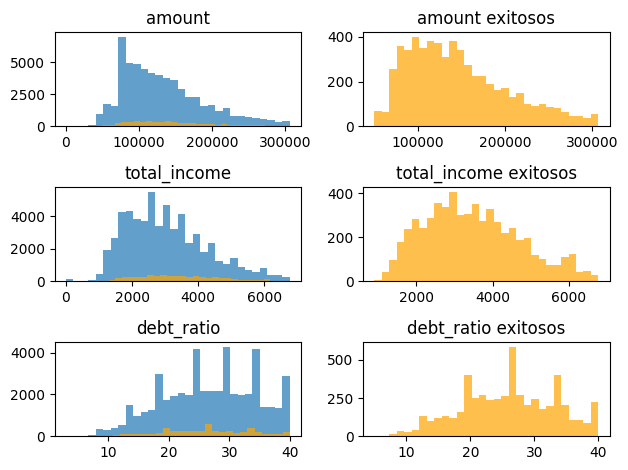

In [122]:
interesting_columns = ['amount', 'total_income', 'debt_ratio']
mask = df['closed_at'].notna()
mask_vendido = mask
fig, ax = plt.subplots(len(interesting_columns), 2)
for i in range(len(interesting_columns)):
    ax[i][0].hist(df[interesting_columns[i]],  bins=30, alpha=0.7)
    ax[i,0].hist(df.loc[mask, interesting_columns[i]],  bins=30, alpha=0.7, color='orange')
    ax[i,1].hist(df.loc[mask, interesting_columns[i]],  bins=30, alpha=0.7, color='orange')
    ax[i, 0].set_title(interesting_columns[i])
    ax[i, 1].set_title(interesting_columns[i] + ' exitosos')
    print(f'{interesting_columns[i]} mean: {df[interesting_columns[i]].mean()}, exitosos: {df.loc[mask, interesting_columns[i]].mean()}, diferencia: {df[interesting_columns[i]].mean() - df.loc[mask, interesting_columns[i]].mean()}')

plt.tight_layout()

In [124]:
df_dates = df.loc[mask_vendido, ['date', 'closed_at']].copy()
df_dates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5871 entries, 6 to 65125
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   date       5468 non-null   datetime64[ns, UTC]
 1   closed_at  5871 non-null   object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 137.6+ KB


In [141]:
df_dates['closed_at'] = pd.to_datetime(df_dates['closed_at'], errors='coerce')
df_dates.info()
df_dates['duration'] = (df_dates['closed_at'] - df_dates['date']).dt.days
df_duration = remove_outliers_iqr(df_dates, 'duration', iqr_multiplier=1.5).copy()

<class 'pandas.core.frame.DataFrame'>
Index: 5871 entries, 6 to 65125
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                    
---  ------     --------------  -----                    
 0   date       5468 non-null   datetime64[ns, UTC]      
 1   closed_at  2973 non-null   datetime64[ns, UTC+01:00]
 2   duration   2864 non-null   float64                  
dtypes: datetime64[ns, UTC+01:00](1), datetime64[ns, UTC](1), float64(1)
memory usage: 183.5 KB
Removed 153 outliers from 'duration' using IQR method (multiplier=1.5).


Mean days: 33.35824022346369, moda days: 0    7.0
Name: duration, dtype: float64


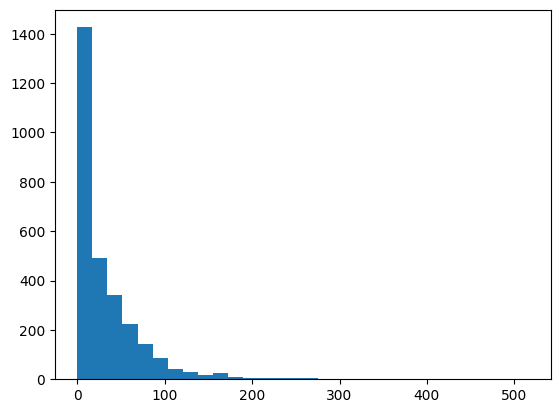

In [142]:
plt.hist(x=df_dates['duration'], bins=30)
print(f"Mean days: {df_dates['duration'].mean()}, moda days: {df_dates['duration'].mode()}")

Mean days: 33.35824022346369, moda days: 0    7.0
Name: duration, dtype: float64


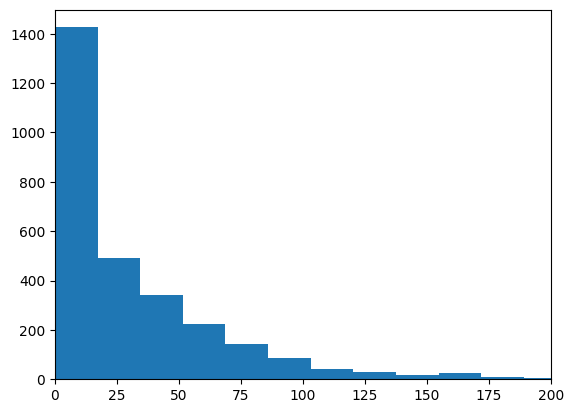

In [144]:
plt.hist(x=df_dates['duration'], bins=30)
plt.xlim(0,200)
print(f"Mean days: {df_dates['duration'].mean()}, moda days: {df_dates['duration'].mode()}")